In [13]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style.txt')

import sys
sys.path.insert(0,'../data_utils/SampleClass/')
from OrigamiTransform import OrigamiTransform
from Distances import Distances, Normalizer
from Coordinates import Coordinates

sys.path.insert(1,'../data_utils/')
from HiCMap import HiCMap
from HiCDataset import HiCDataset

In [2]:
num_beads = 64#128
resolution = 20_000

In [3]:
mcool_fp_GM = '../../data/outside/GM12878_hg19.mcool'
mcool_fp_IMR = '../../data/outside/IMR90_hg19.mcool'
if num_beads == 64:
    sample_folder = '../../data/samples/origami_64_no_embed_reduction/eval_mode/'
    embedding_dir = '../../data/embeddings_64_after_transformer/'
elif num_beads == 128:
    sample_folder = '../../data/samples/origami_128_no_embed_reduction/'
    embedding_dir = '../../data/embeddings_128_after_transformer/'
else:
    raise Exception('Need to place filepaths for this!')
origami_transform = OrigamiTransform()

In [4]:
normalizer = Normalizer(mean_dist_fp='../../data/mean_dists.pt',mean_sq_dist_fp='../../data/squares.pt')

In [5]:
def drop_inf_conformations(dists):
    return Distances(dists.values[dists.values.isfinite().all(-1).all(-1)])

In [6]:
def load_dists(fp):
    return drop_inf_conformations(Distances(origami_transform.inverse(torch.load(fp),num_beads).squeeze()).unnormalize_(normalizer))

In [10]:
# Few features
''' 
chrom = 'X'
#region = 1100
region = 1243
'''
if num_beads == 64:
    chrom='1'
    region=330#166
    cond_scale=1.5
    rescaled_phi=.5
elif num_beads == 128:
    chrom = '1'
    region = 330
    cond_scale=4.
    rescaled_phi=.6
filepath = sample_folder + f'sample_{region}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'

In [14]:
dists = torch.load(filepath)
if dists.shape[-1] == 3:
    dists = Coordinates(dists).distances
else:
    dists = Distances(origami_transform.inverse(dists,num_beads).squeeze()).unnormalize_(normalizer)

cond_scale=2.0
filepaths = [
    f'./eval_mode/sample_{region}_{cond_scale}_0.1_120_X.pt',
    f'./eval_mode/sample_{region}_{cond_scale}_0.3_120_X.pt',
    f'./eval_mode/sample_{region}_{cond_scale}_0.5_120_X.pt',
    f'./eval_mode/sample_{region}_{cond_scale}_0.7_120_X.pt',
    f'./eval_mode/sample_{region}_{cond_scale}_0.9_120_X.pt'
]
dists = Distances(origami_transform.inverse(torch.load(filepaths[0]),64).squeeze()).unnormalize_(normalizer)
for f in filepaths[1:]:
    dists.append(Distances(origami_transform.inverse(torch.load(f),64).squeeze()).unnormalize_(normalizer))
dists = drop_inf_conformations(dists)

# For GM vs IMR comparison
filepath = './cross_validation/IMR/chr_11_2000_1.5_0.5.pt'
dists = Distances(origami_transform.inverse(torch.load(filepath),64).squeeze())

In [15]:
dists = drop_inf_conformations(dists)

In [16]:
def plot(dmap):
    dmap = dmap.values.squeeze()
    if dmap.ndim > 2:
        dmap = dmap.flatten(0,-3).mean(0)
    assert dmap.ndim == 2 and dmap.shape[0]==dmap.shape[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #i,j = torch.triu_indices(dmap.shape[-1],dmap.shape[-1],1)
    #im = ax.matshow(dmap.cpu().numpy(),vmin=dmap[i,j].min(),vmax=dmap[i,j].max(),cmap='coolwarm')#'seismic')
    im = ax.matshow(-dmap.cpu().numpy(),cmap='coolwarm')#'seismic')
    cbar = fig.colorbar(im)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Genomic Position')
    ax.set_ylabel('Genomic Position')
    #cbar.ax.set_yticks([i for i in cbar.ax.get_yticks() if int(i)==float(i)])
    #cbar.set_ticks([i for i in cbar.get_ticks() if int(i)==float(i)])
    '''
    ticklabels = []
    for label in cbar.ax.get_yticklabels():
        tl = label.get_text().split('{')
        if len(tl) == 1:
            tl = tl[0]
        else:
            tl = tl[1].split('}')[0]
        tl = tl.replace('-')
        tl = '$\\mathdefault{' + str(abs(int(tl))) + '}$'
        ticklabels.append(str(abs(int(tl))))
    cbar.ax.set_yticklabels(ticklabels)
    '''
    cbar.ax.set_yticklabels([l.get_text().replace('−','') for l in cbar.ax.get_yticklabels()])
    return fig, ax, im, cbar

/state/partition1/slurm_tmp/25461430.0.0/ipykernel_2847759/417366534.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([l.get_text().replace('−','') for l in cbar.ax.get_yticklabels()])


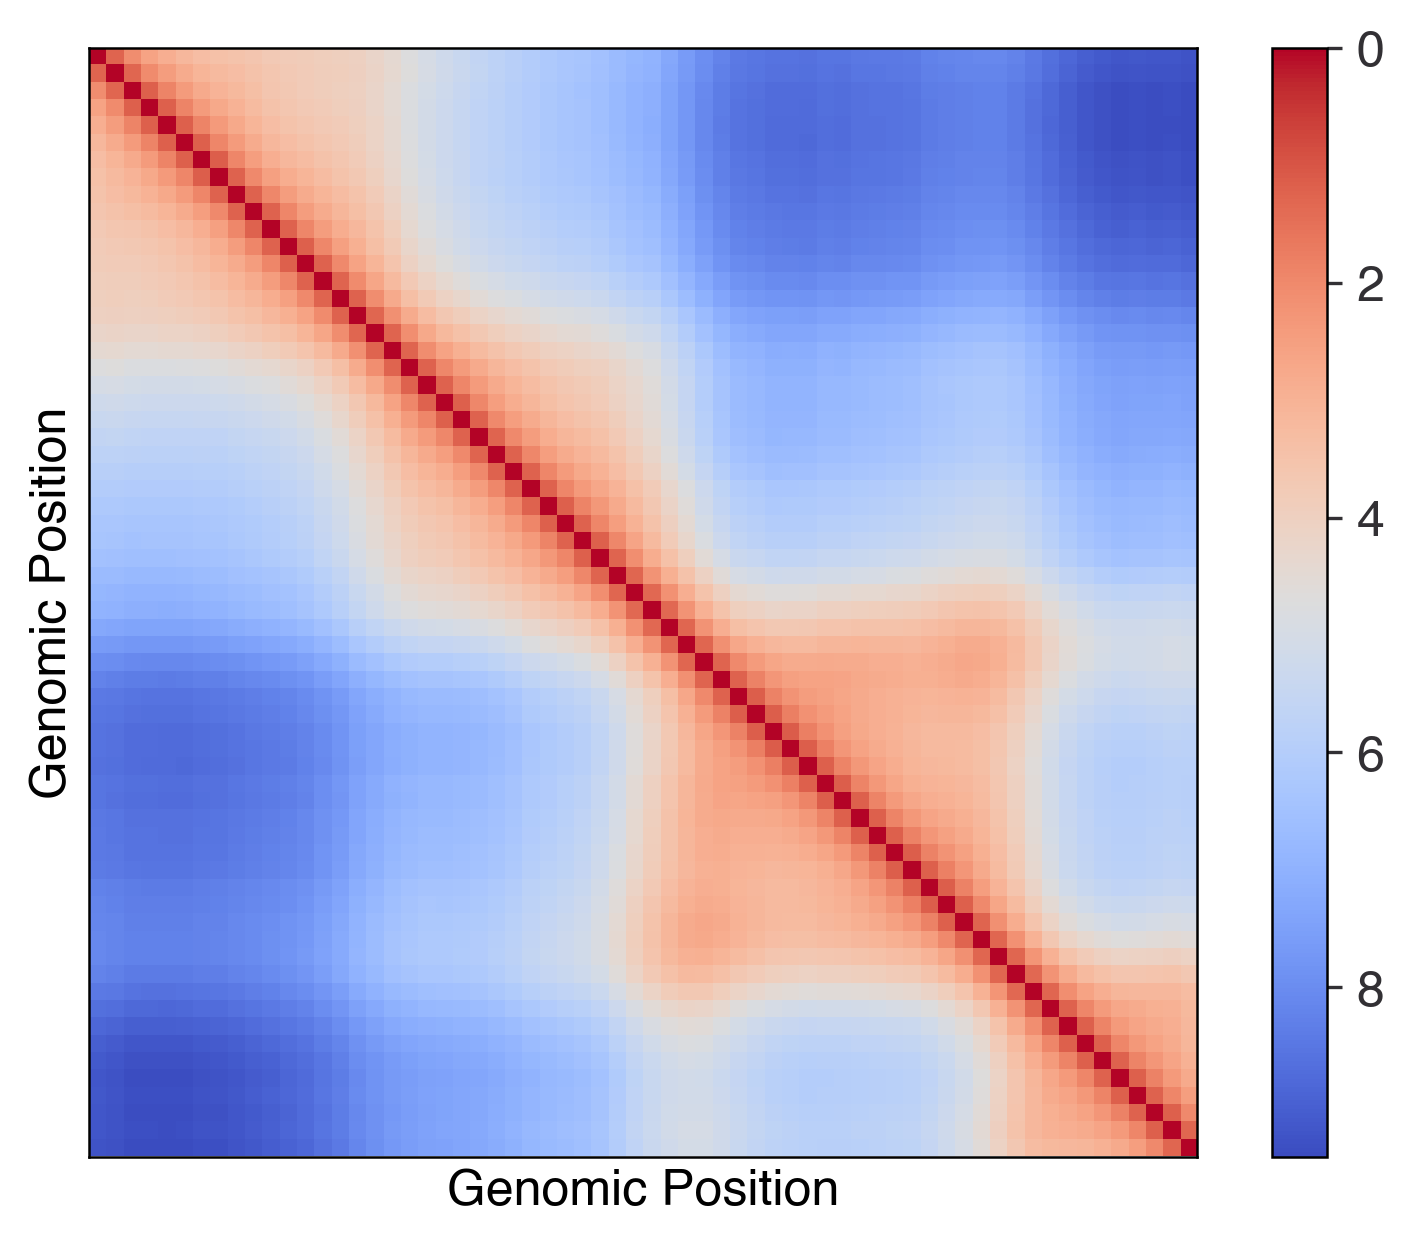

In [17]:
fig,ax,im,cbar = plot(dists)

In [18]:
def tanh_map(dists,r_c=.6,sigma=.1):
    '''
    Avoids using the distance correction approach
    '''
    
    r = dists.values.clone()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**3
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=True)

In [19]:
exp_hic = HiCDataset(mcool_fp_GM)
rosetta = pd.read_pickle(f'{embedding_dir}/rosetta_stone.pkl')

Text(0.64, 62.68, 'Generated')

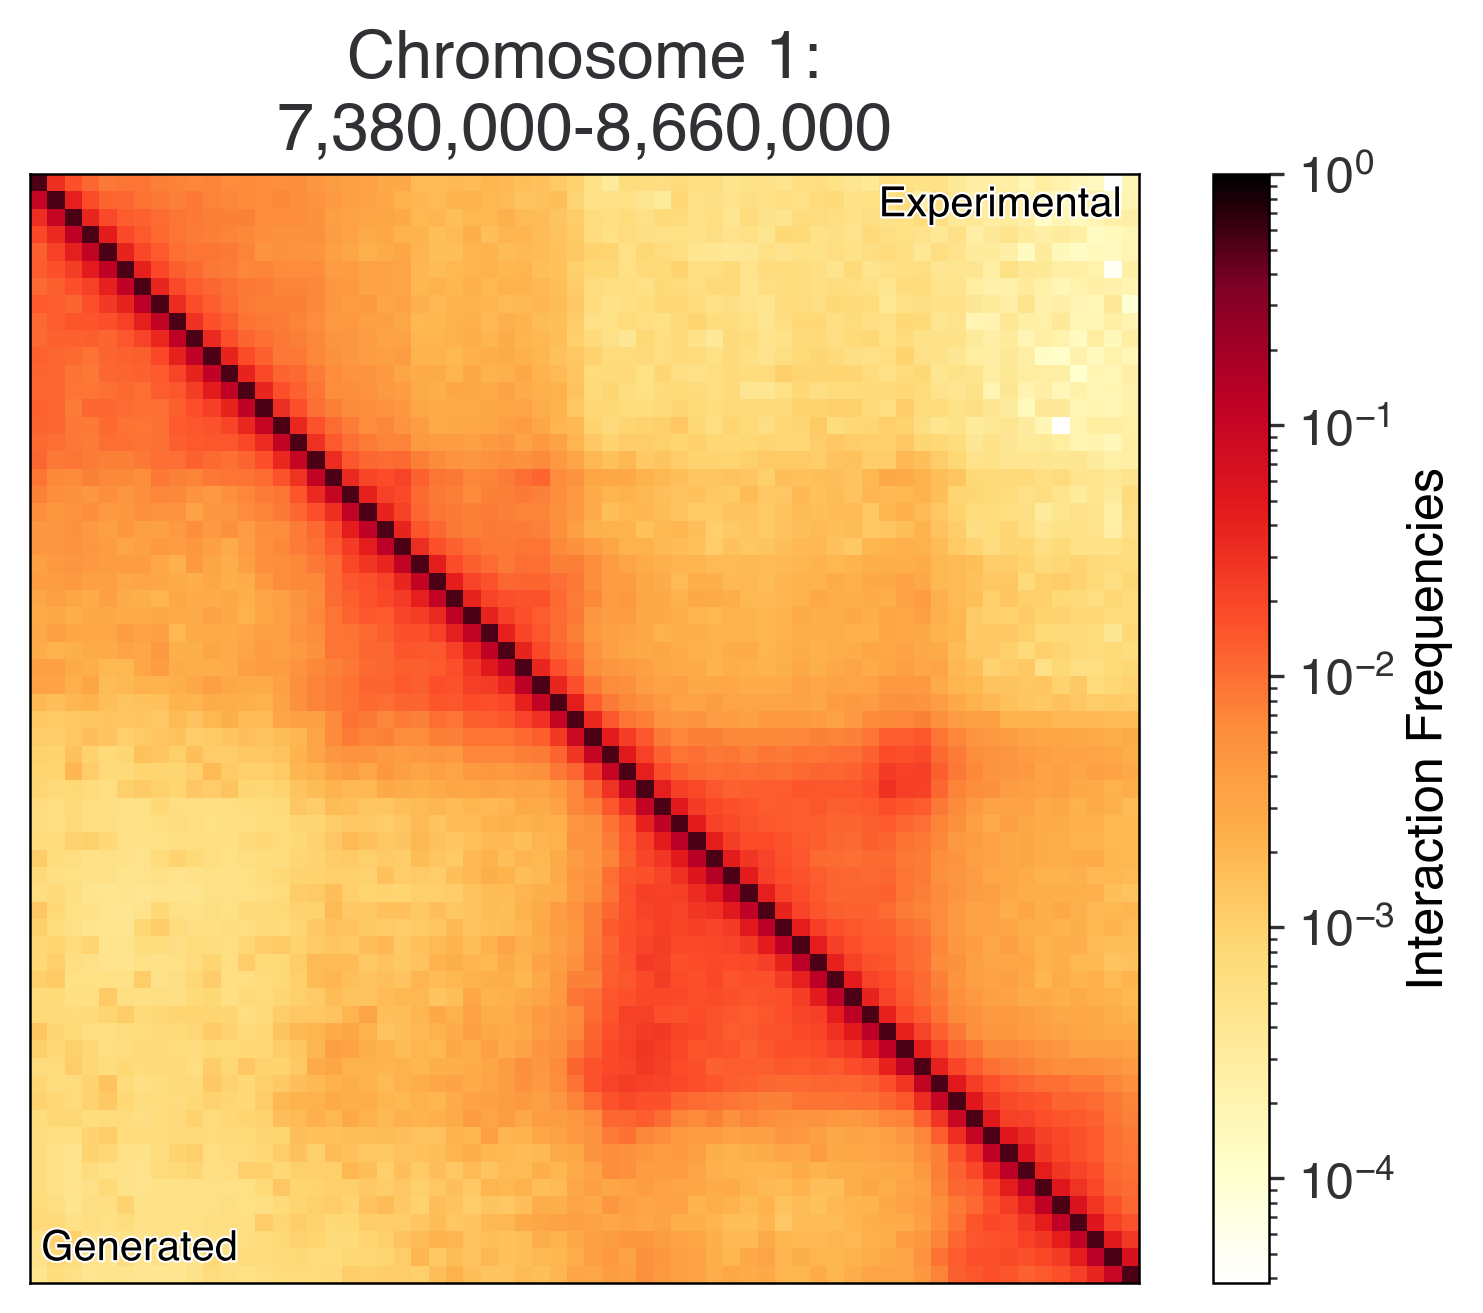

In [20]:
gen_map = tanh_map(dists).prob_map
start = rosetta[chrom][region][-1]
exp_map = exp_hic.fetch(chrom=chrom,start=start,stop=start+num_beads*resolution).prob_map

assert gen_map.shape==exp_map.shape

i,j = torch.triu_indices(gen_map.shape[-1],gen_map.shape[-1],1)
gen_map[i,j] = exp_map[i,j]
gen_map = HiCMap(gen_map)
fig,ax,im,cbar = gen_map.plot()

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{start+1_280_000:,}')
ax.text(num_beads-1,.01*num_beads,'Experimental',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_beads,.995*num_beads-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

In [34]:
def plot_dmap(coords,chrom=None,start=None,stop=None,vmin=None,vmax=None):

    assert coords.ndim > 0
    
    while coords.ndim < 3:
        coords = coords.unsqueeze(0)
    coords = coords.flatten(0,-3)
    if coords.shape[-1] == 3:
        mean_dists = coords_to_dists(coords).mean(0)
    else:
        mean_dists = coords.mean(0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(-mean_dists.cpu().numpy(),cmap='coolwarm',vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(im)
    cbar.set_ticklabels([
        f'{abs(int(label))}' for label in cbar.get_ticks()
    ])
    cbar.set_label('Distance (mean bond length)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig,ax,im,cbar

/state/partition1/slurm_tmp/25408422.0.0/ipykernel_2357750/3009119768.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([


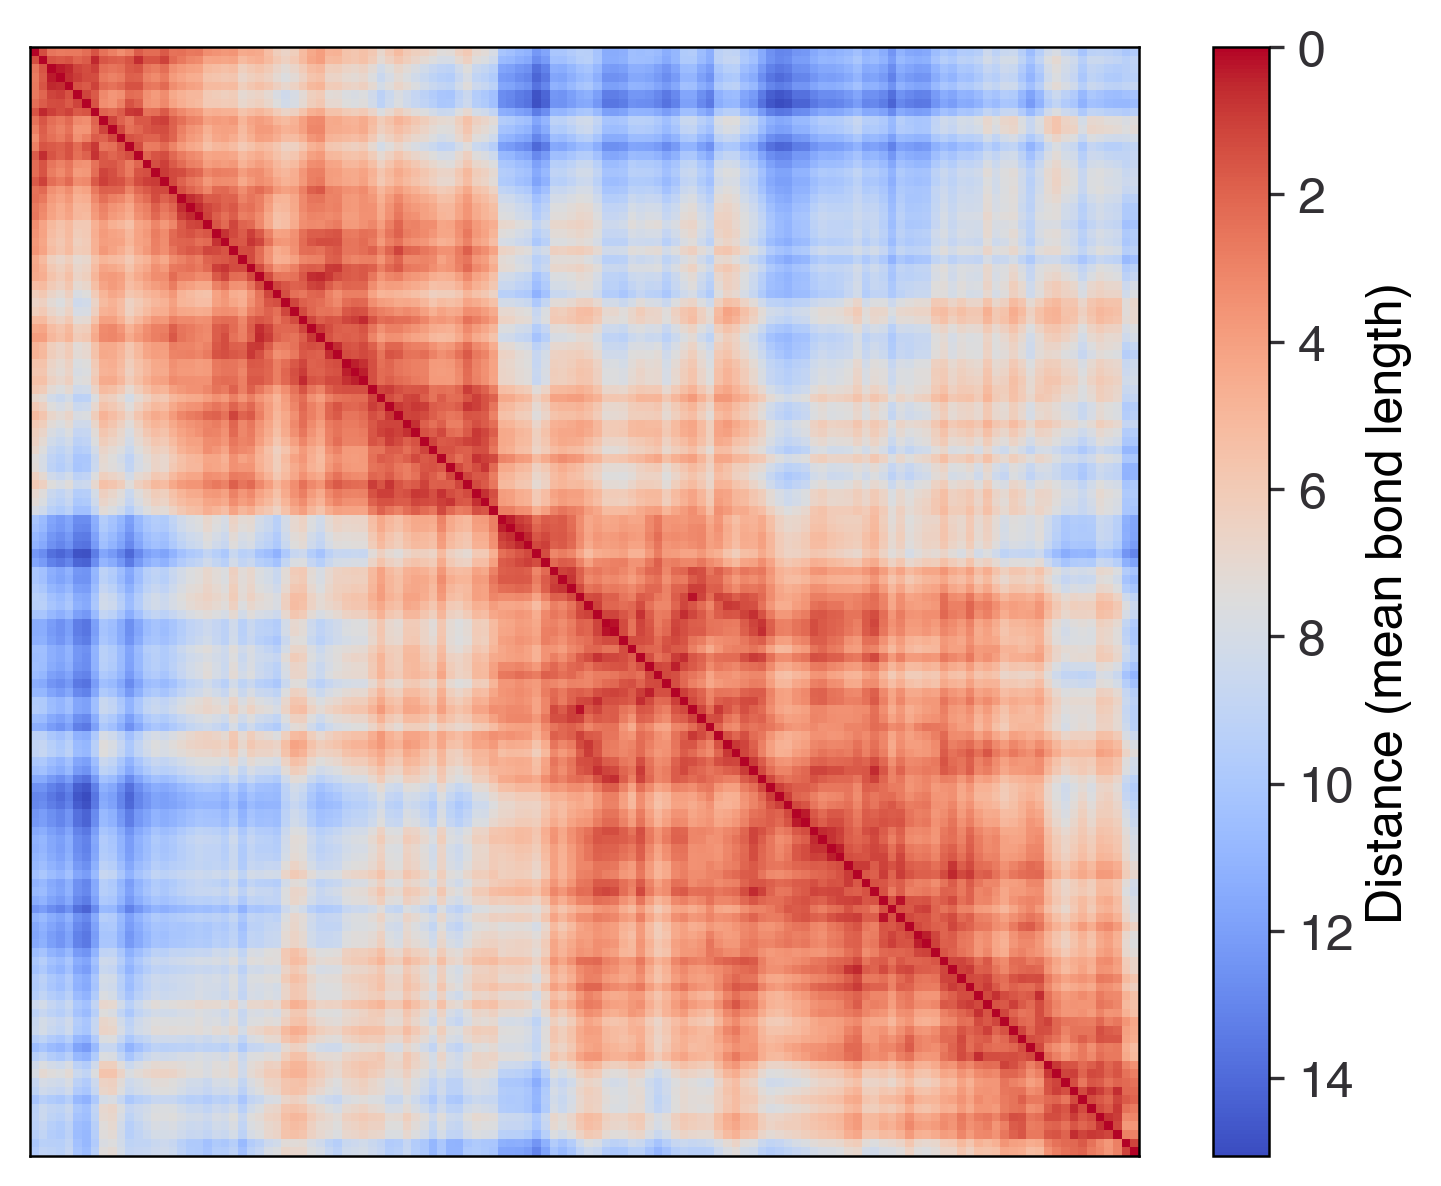

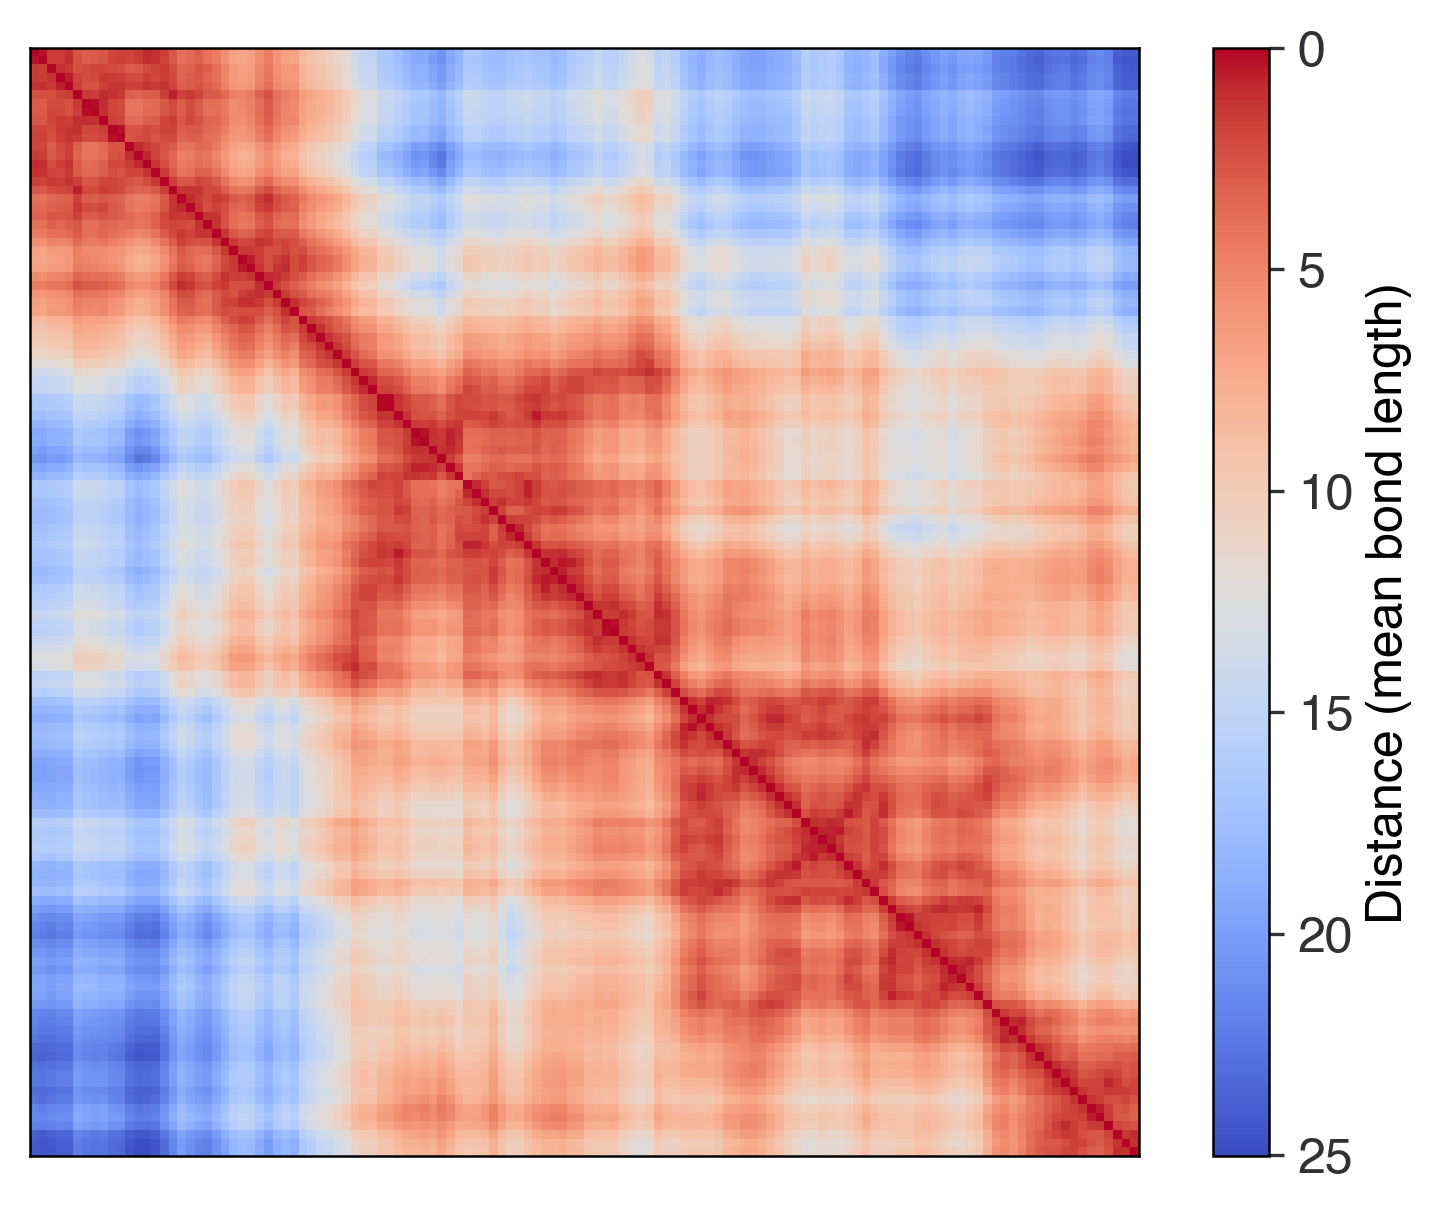

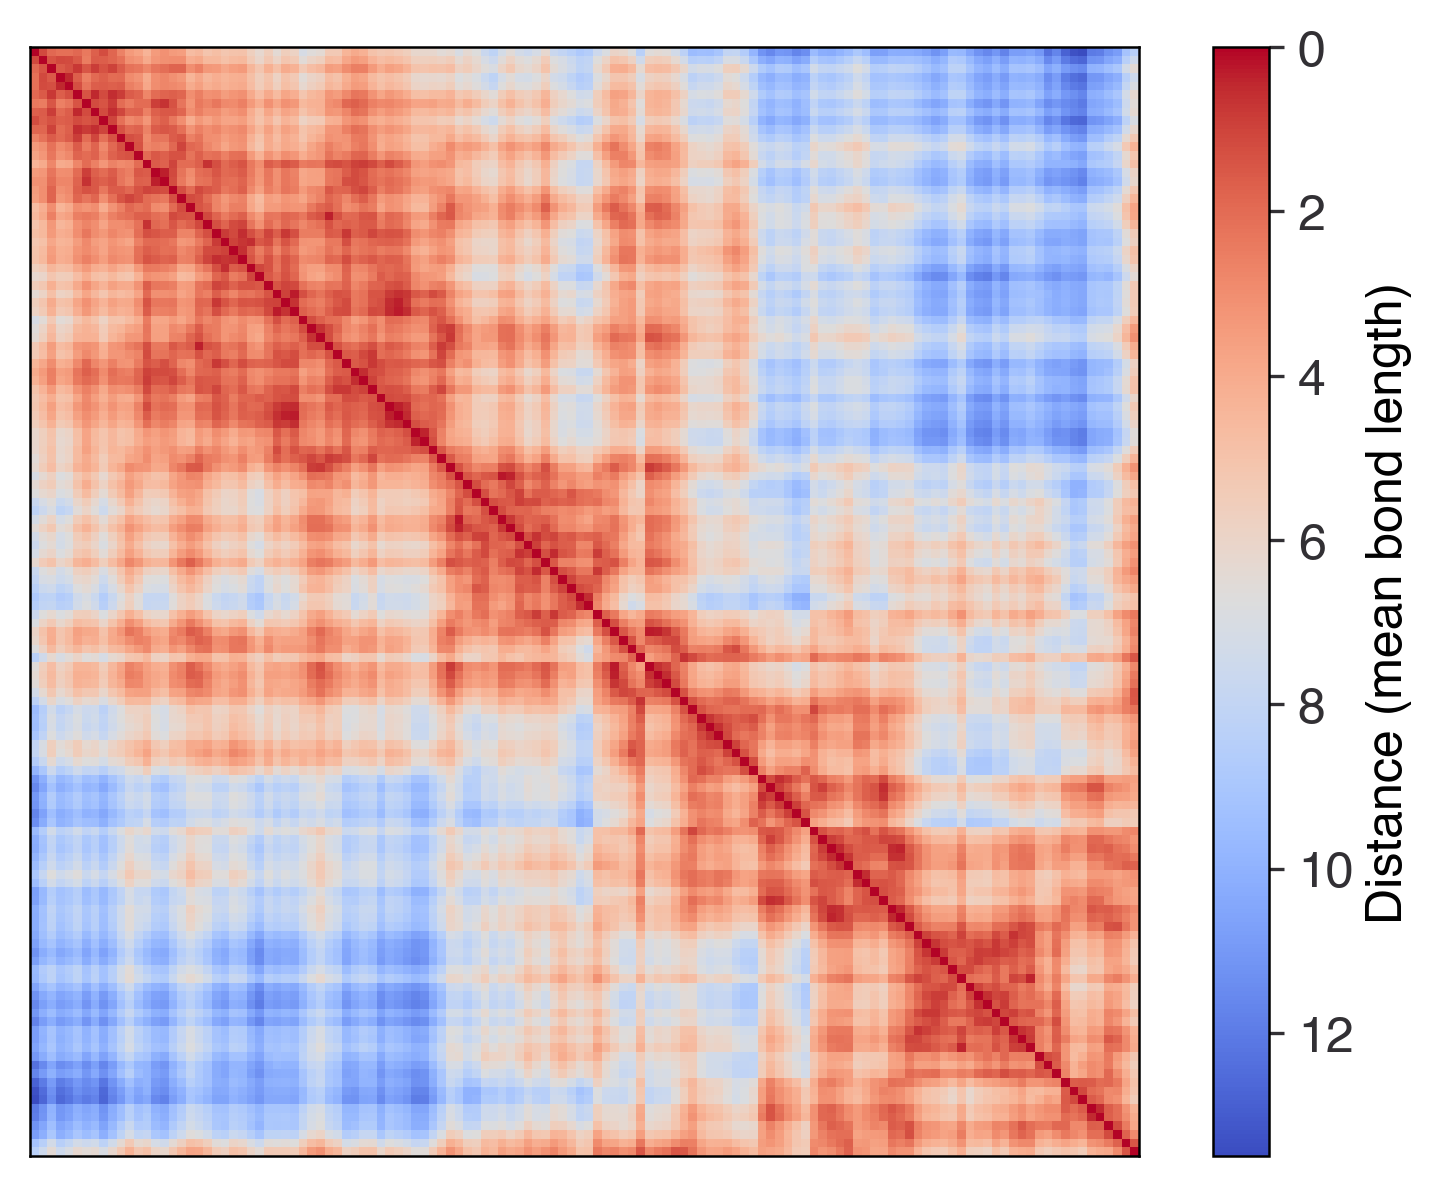

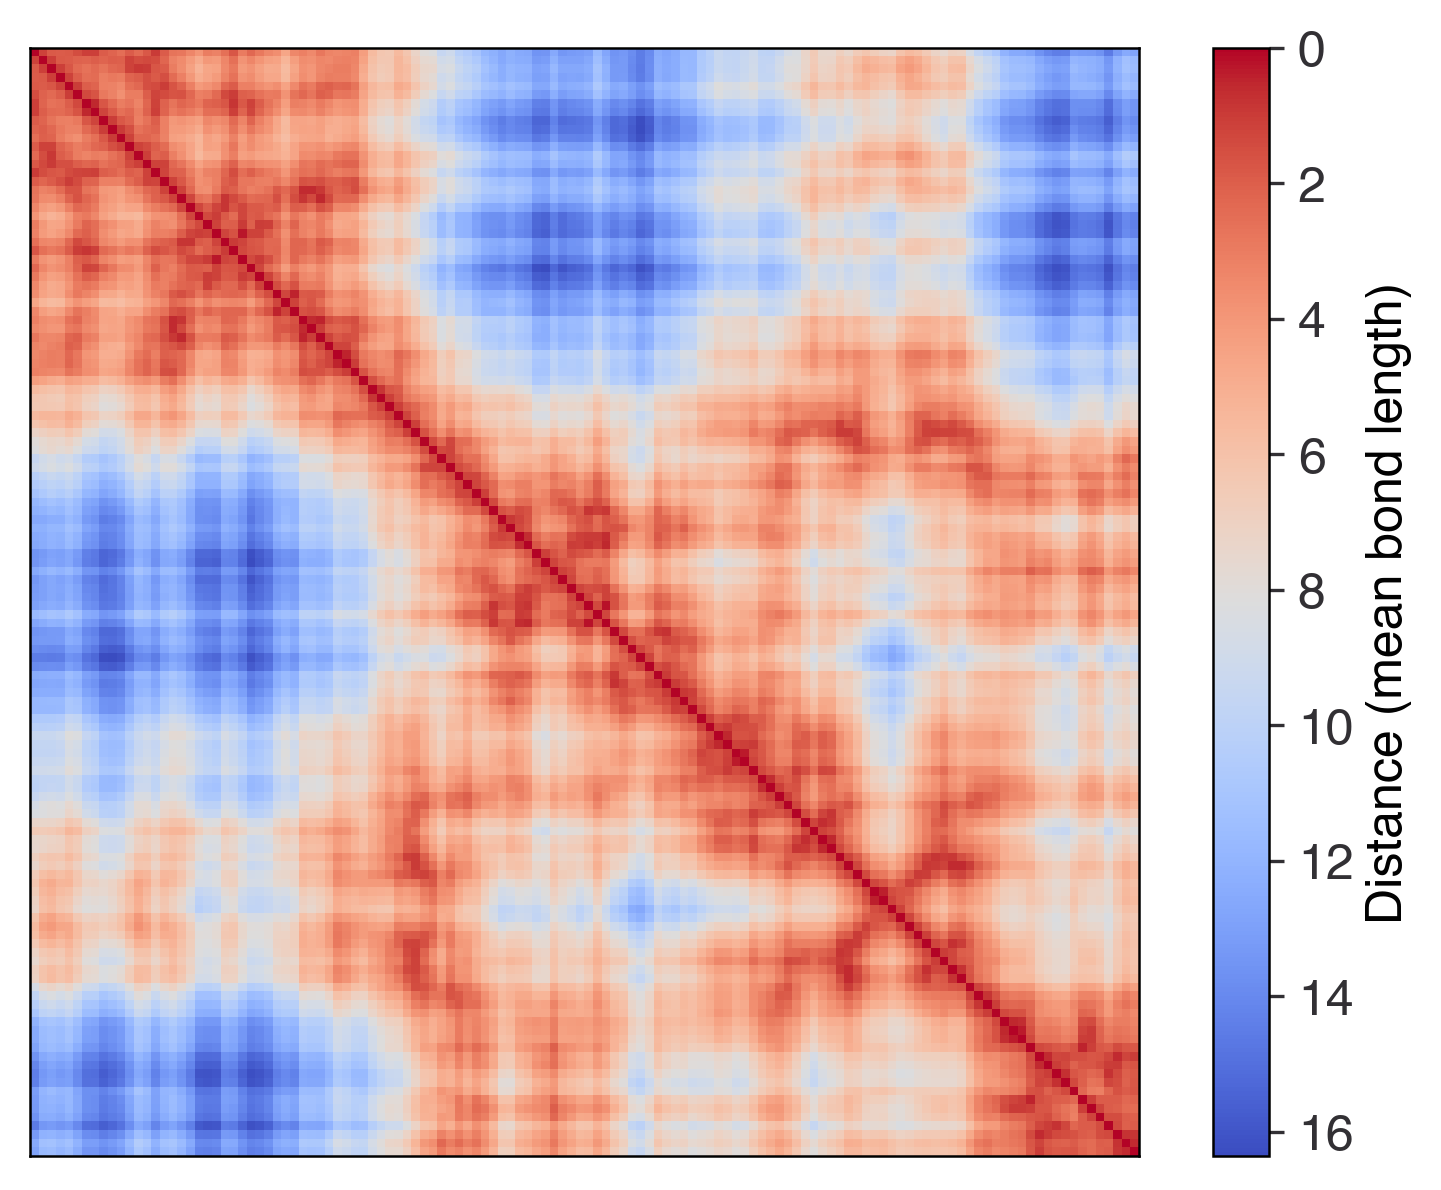

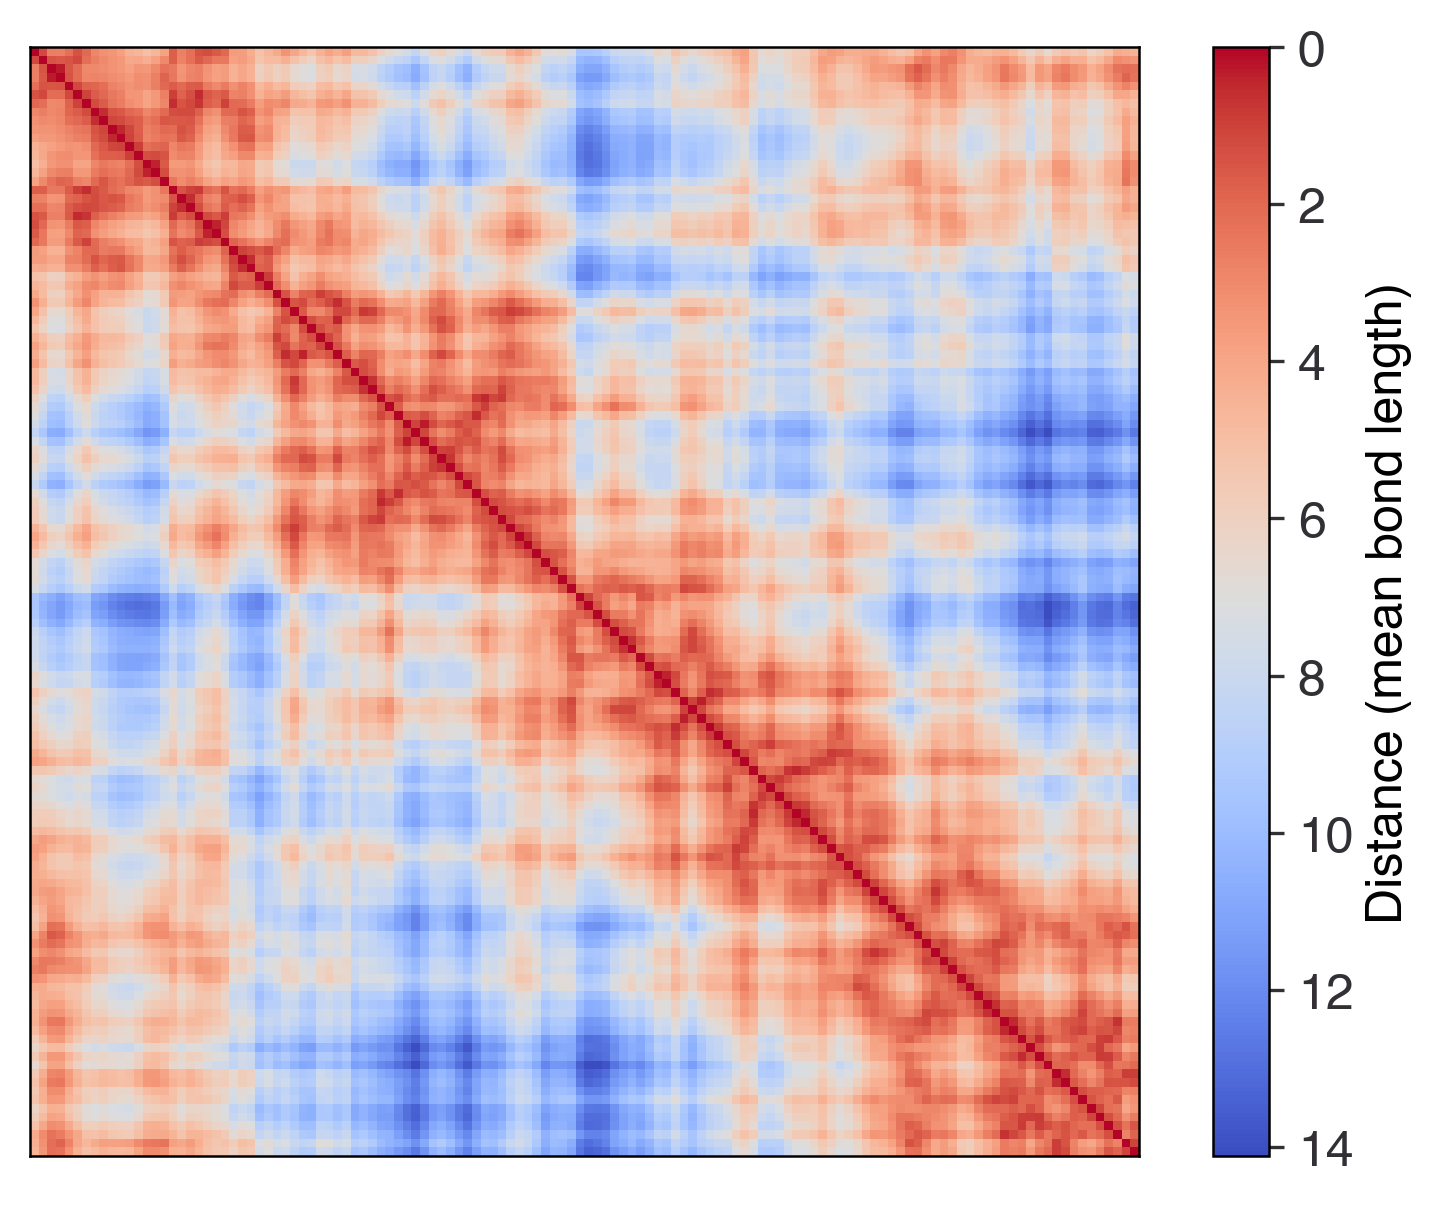

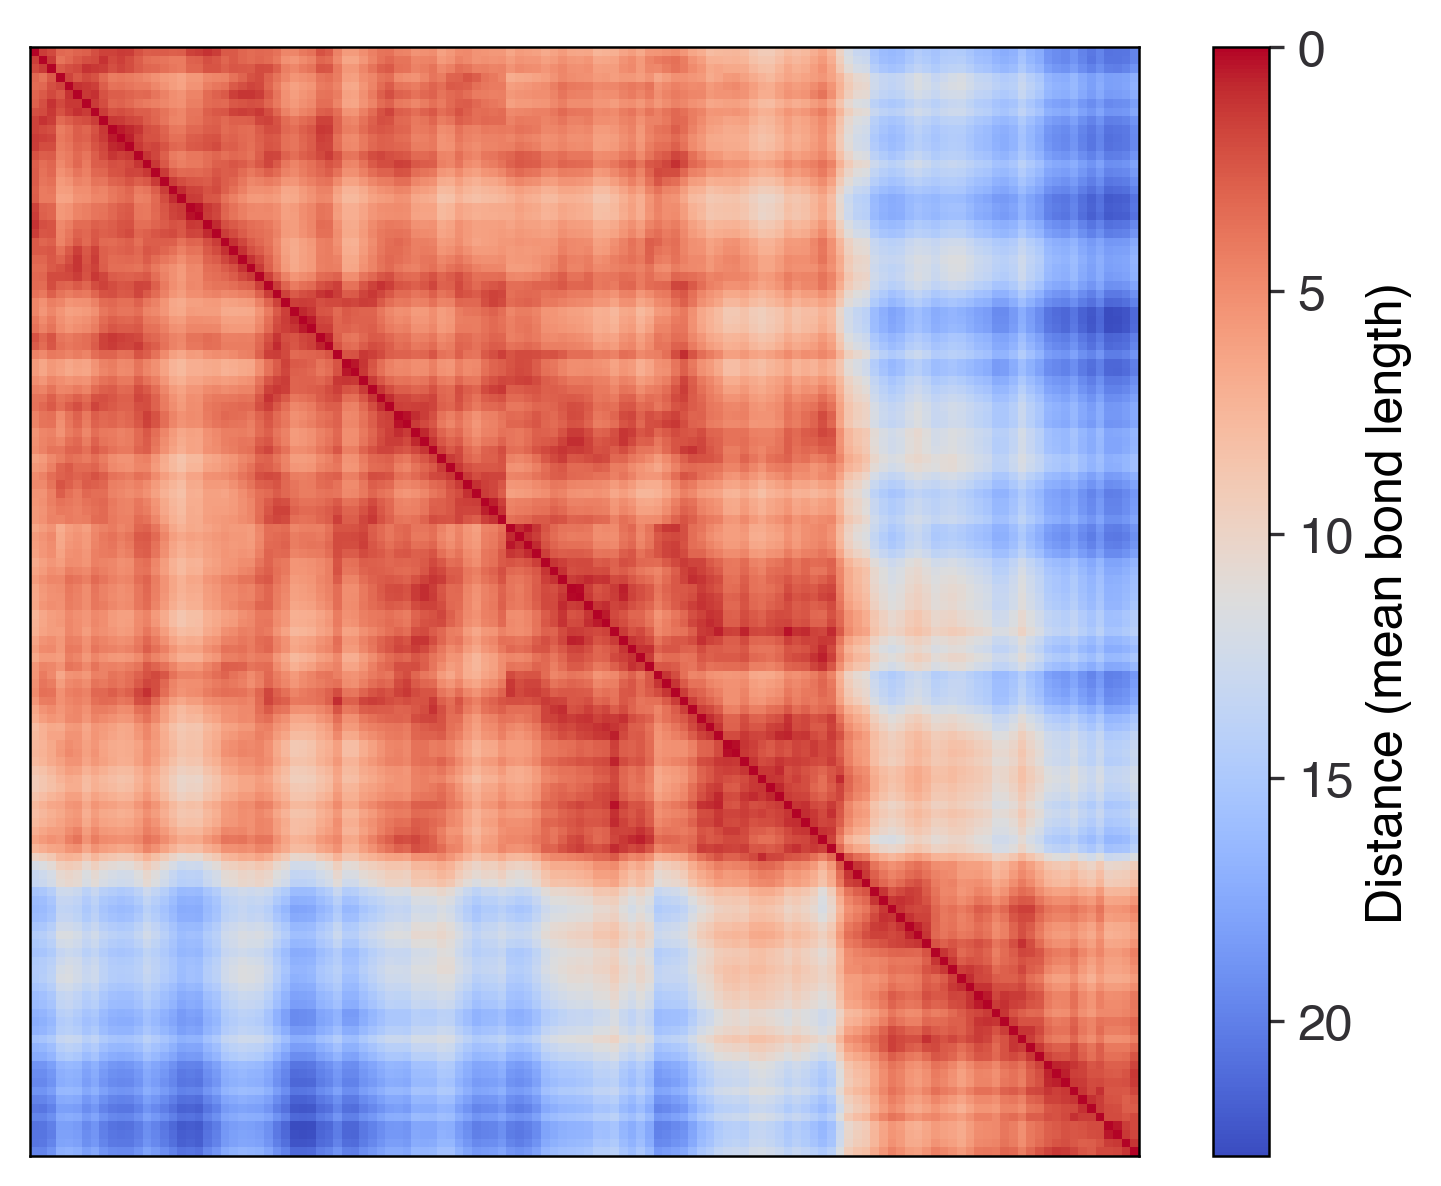

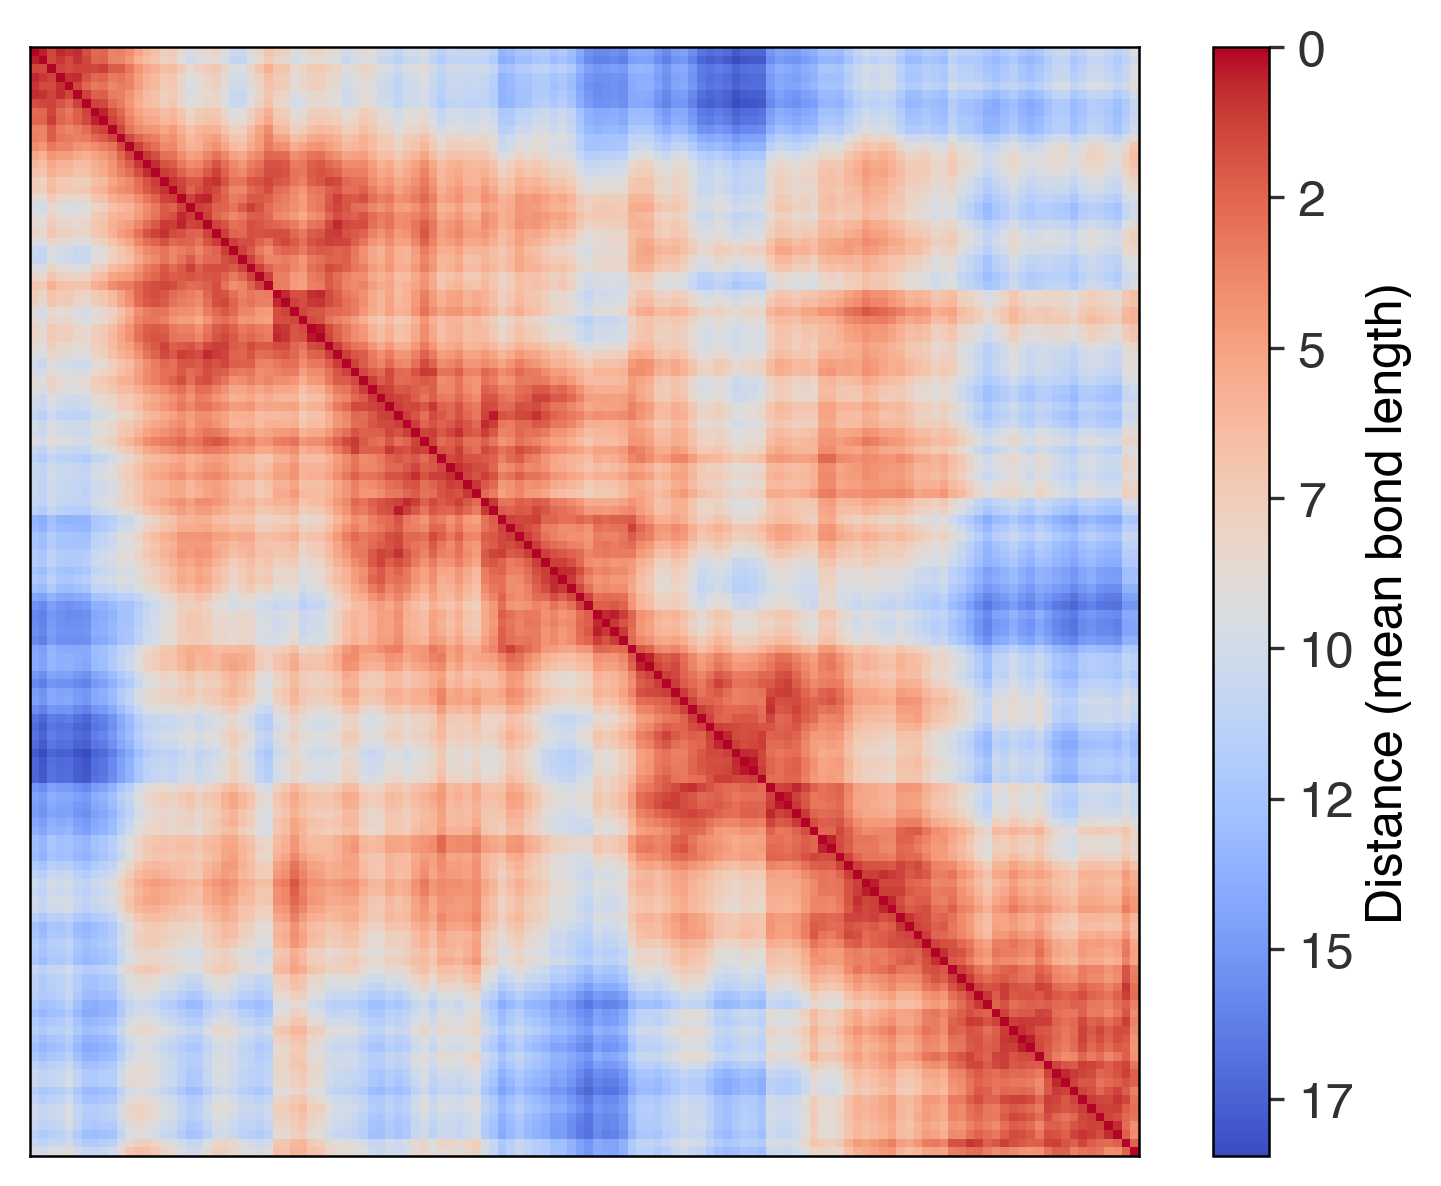

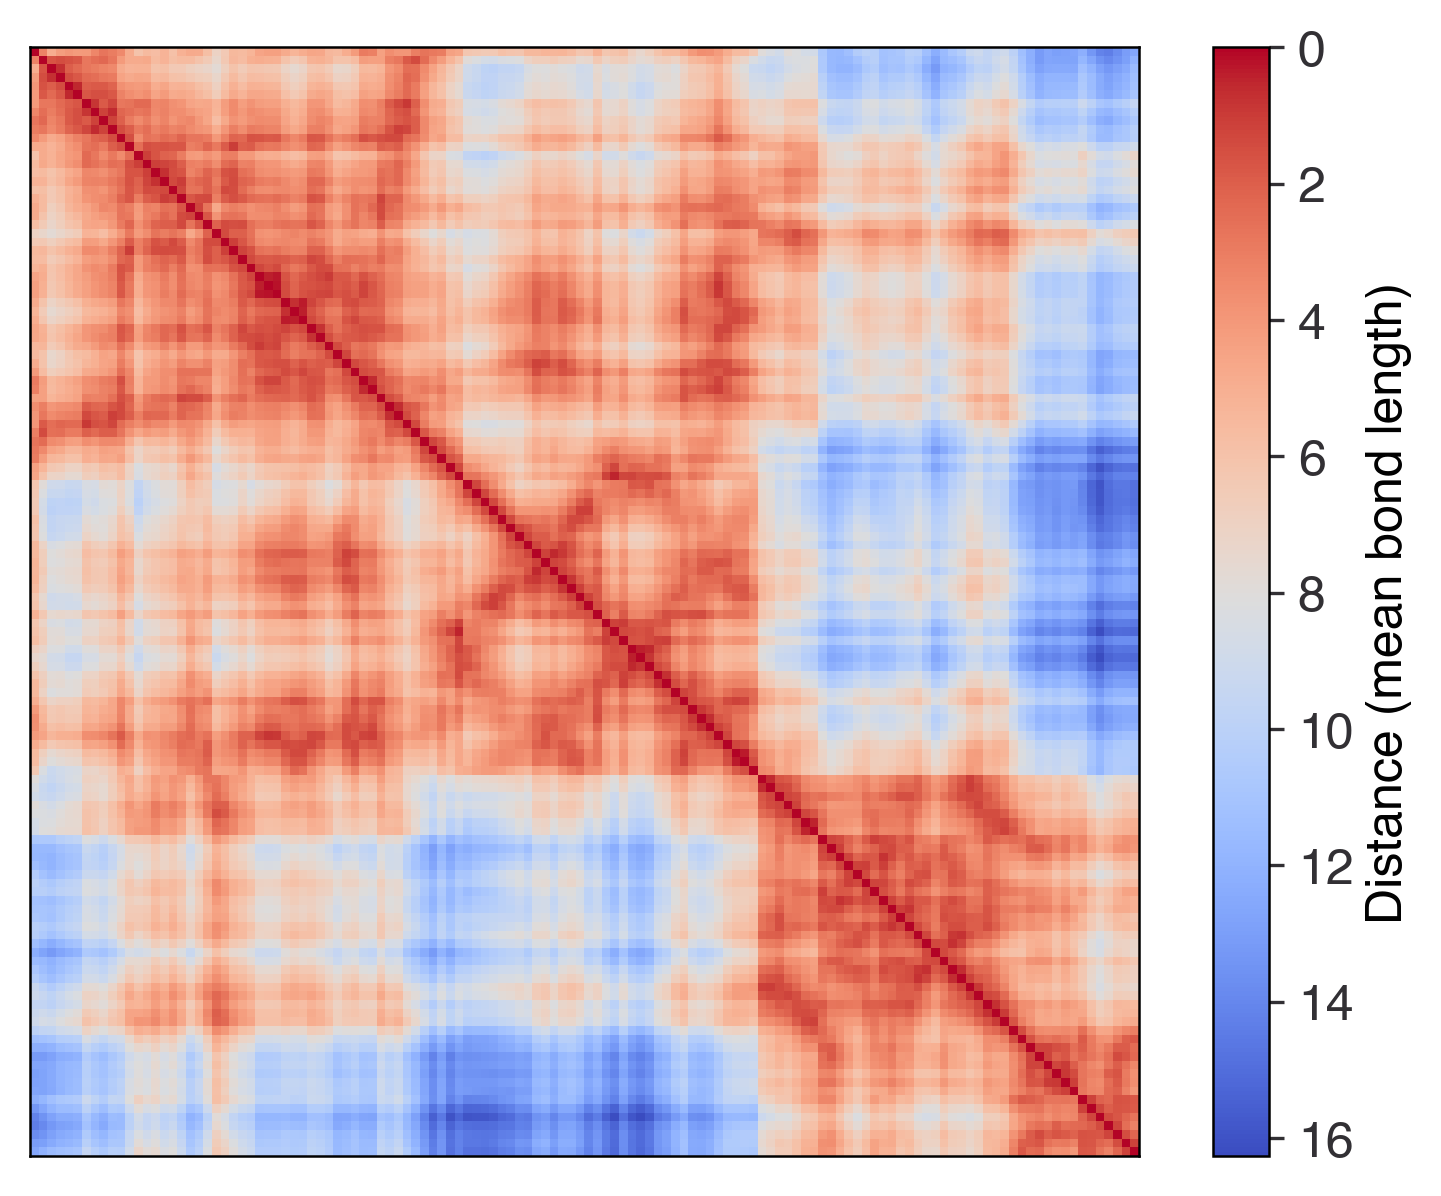

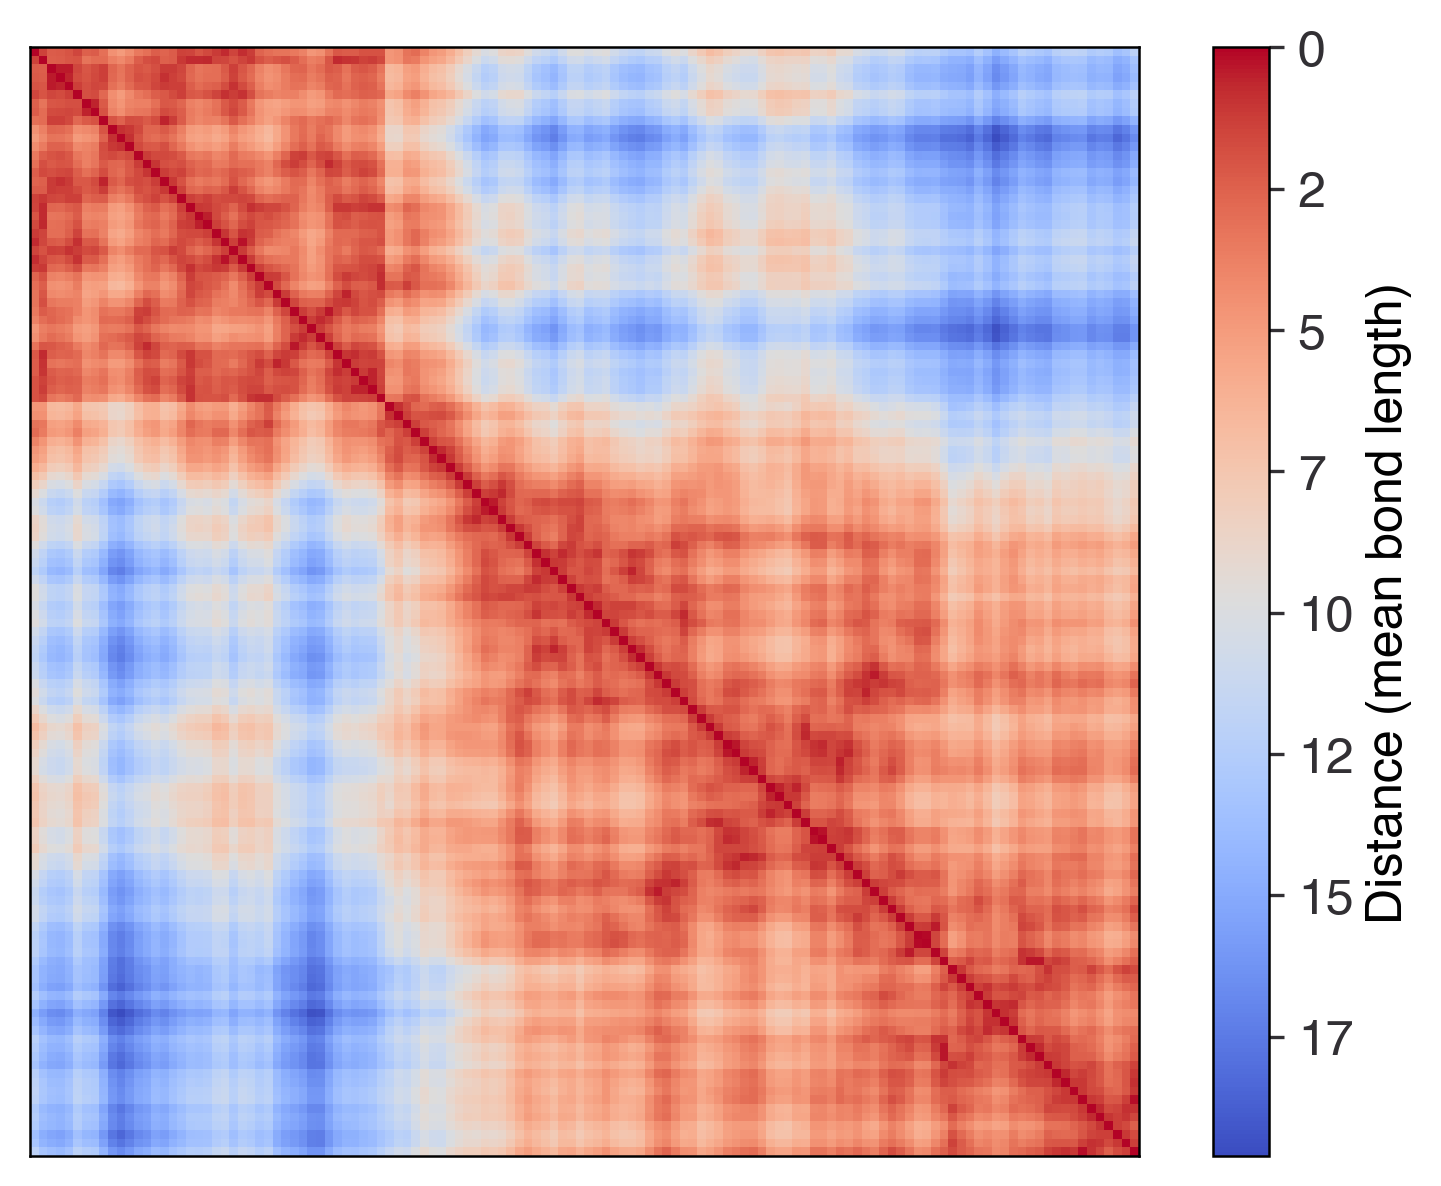

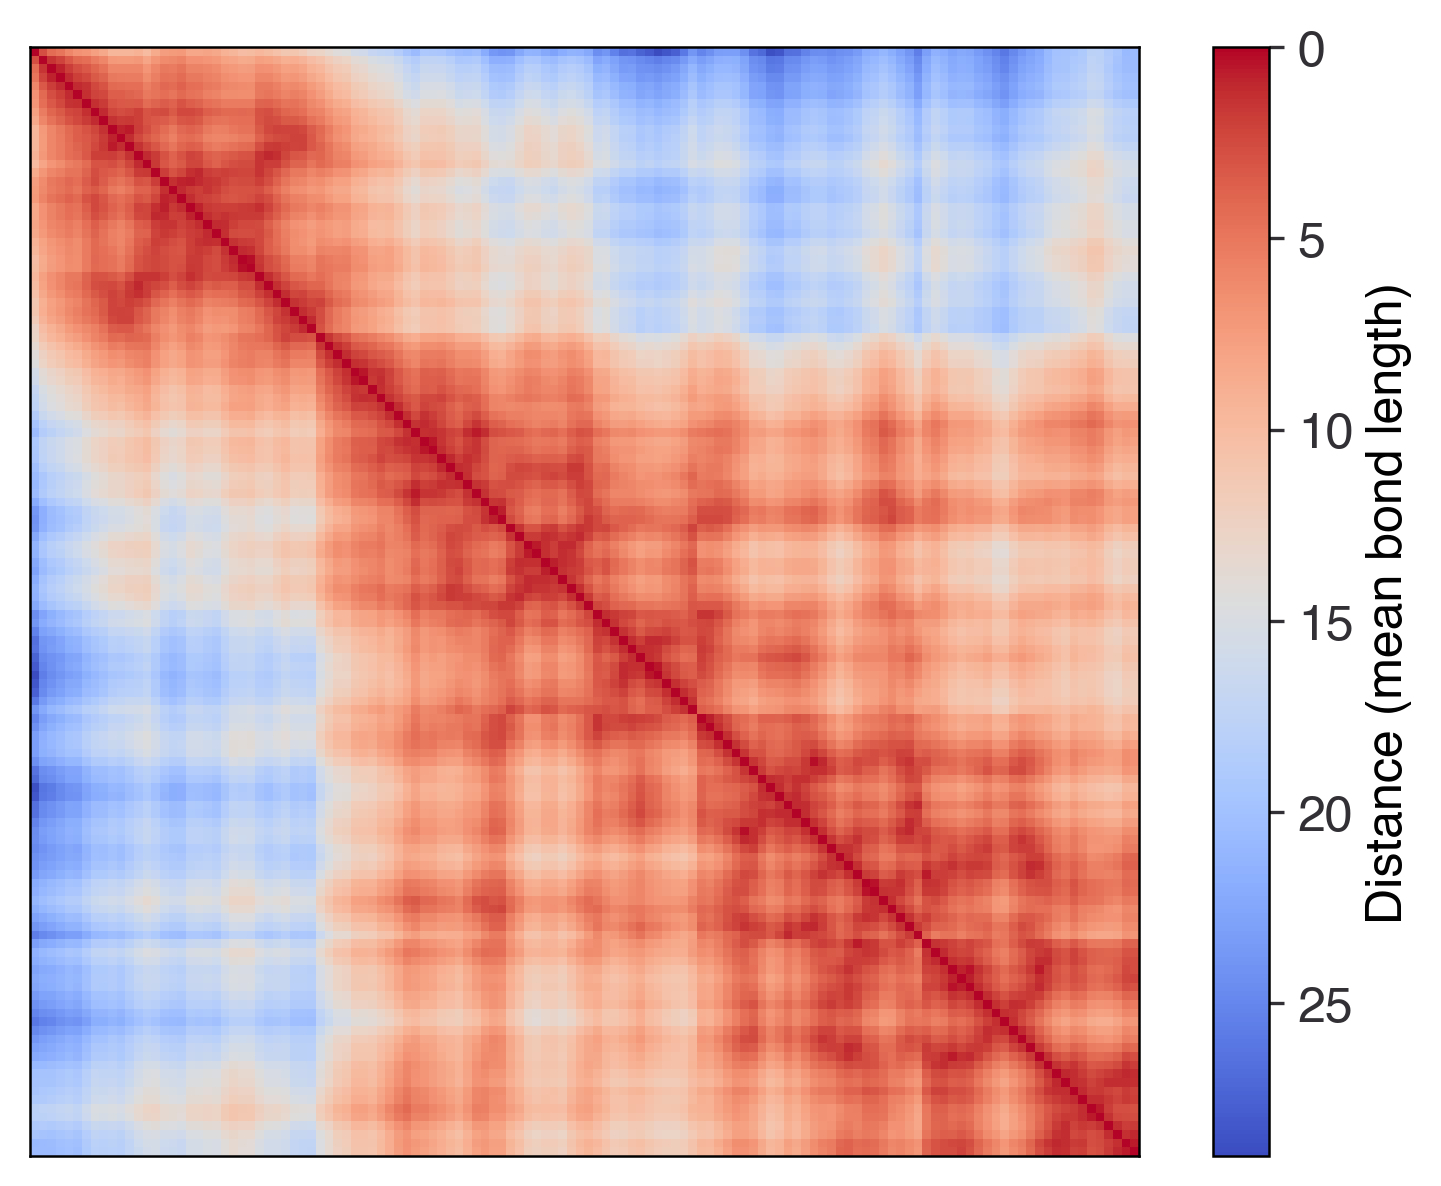

In [35]:
for i in range(10):
    fig,ax,im,cbar = plot_dmap(dists[i].values)

In [22]:
def plot_difference(coords,mean_dists,chrom=None,start=None,stop=None,vmin=None,vmax=None):

    assert coords.ndim > 0
    
    while coords.ndim < 3:
        coords = coords.unsqueeze(0)
    coords = coords.flatten(0,-3)
    '''
    if coords.shape[-1] == 3:
        mean_dists = coords_to_dists(coords).mean(0)
    else:
        mean_dists = coords.mean(0)
    '''
    delta = coords - mean_dists
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(delta.squeeze().cpu().numpy(),cmap='coolwarm',vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(im)
    #cbar.set_ticklabels([
    #    f'{abs(int(label))}' for label in cbar.get_ticks()
    #])
    cbar.set_label('Distance - <Distance> (mean bond length)')

    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig,ax,im,cbar

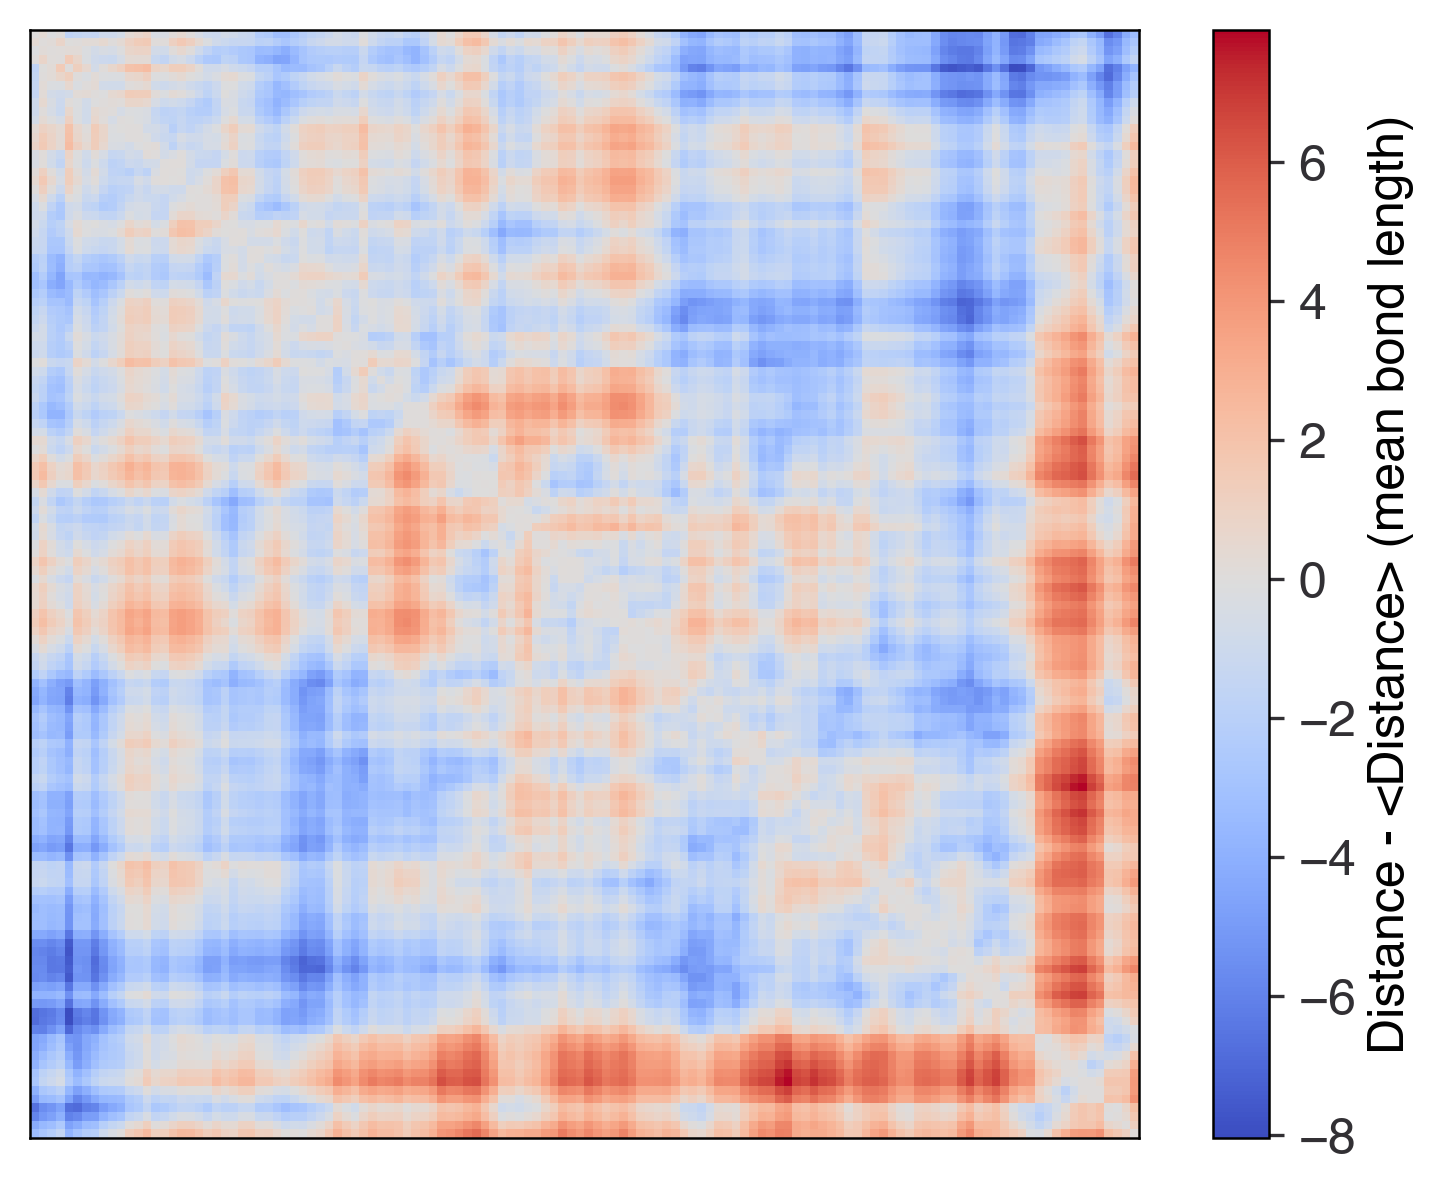

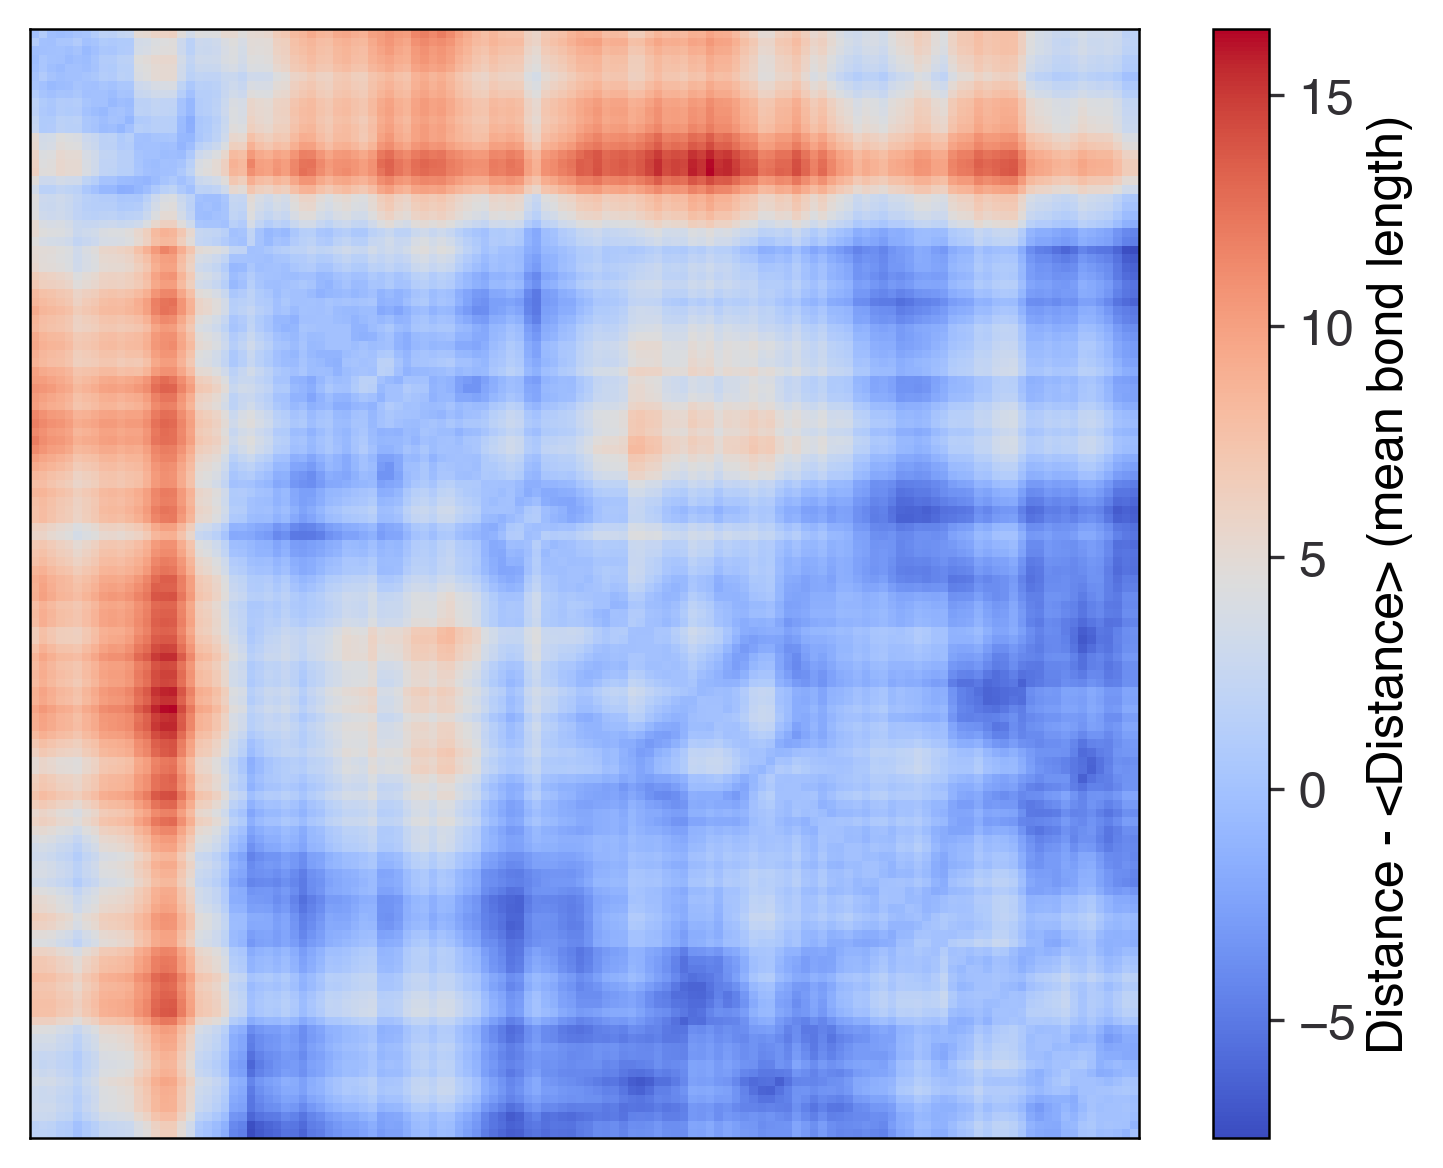

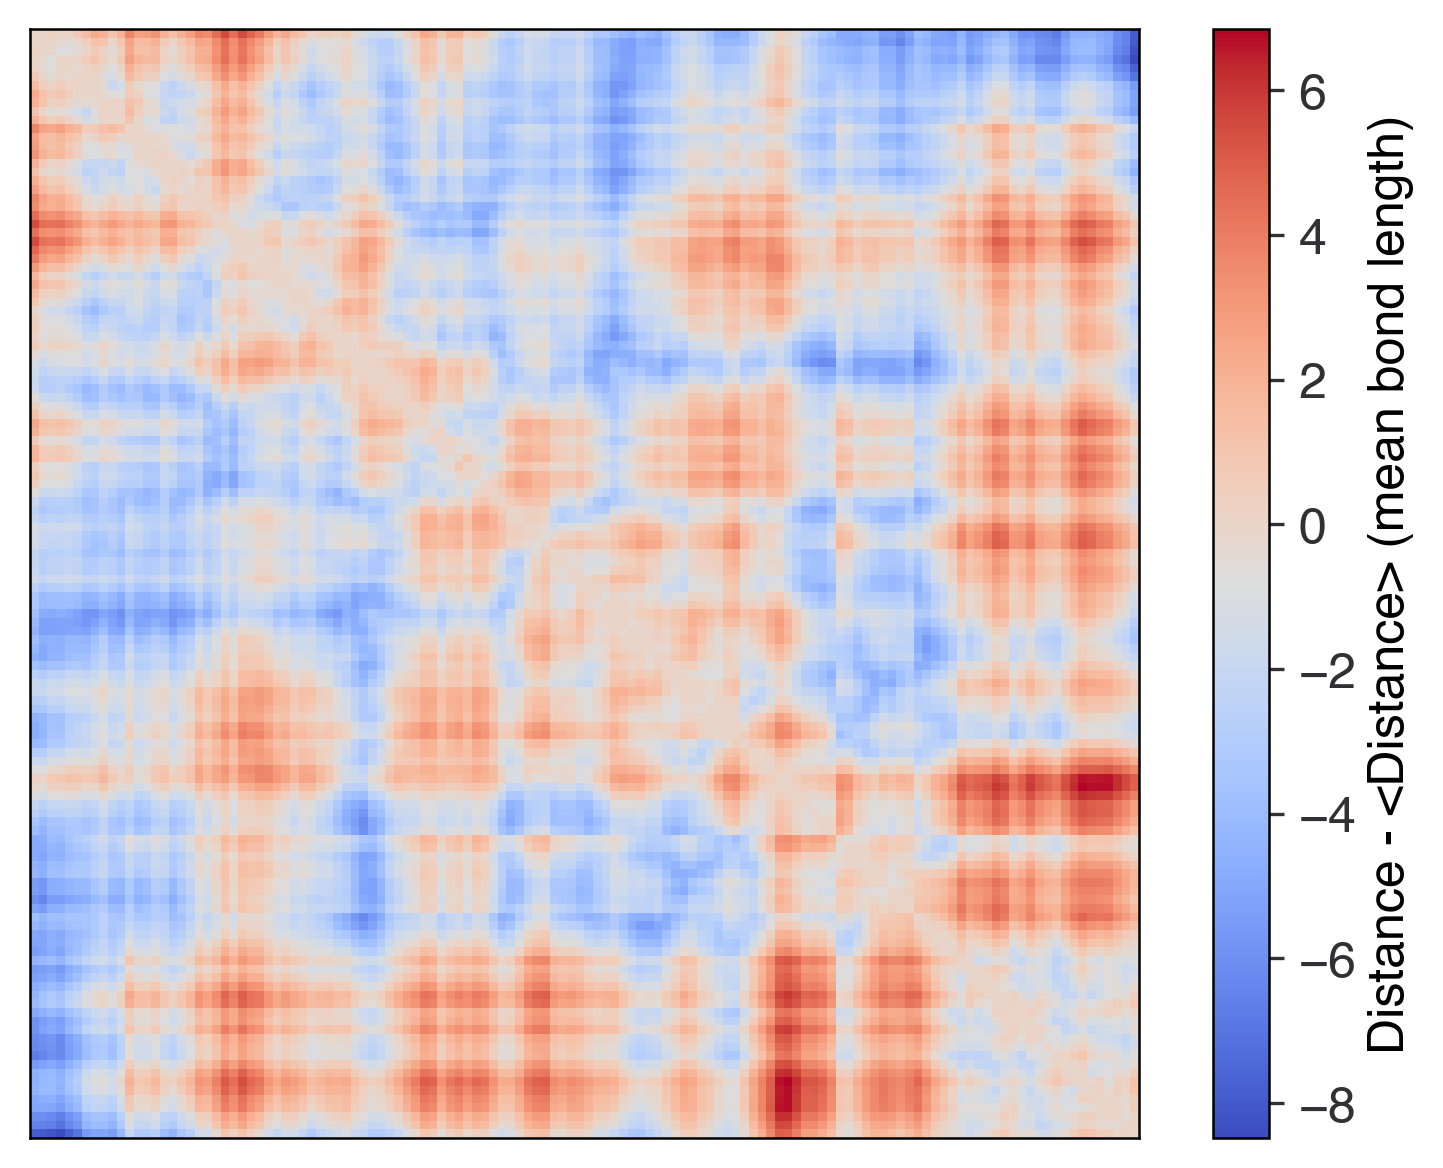

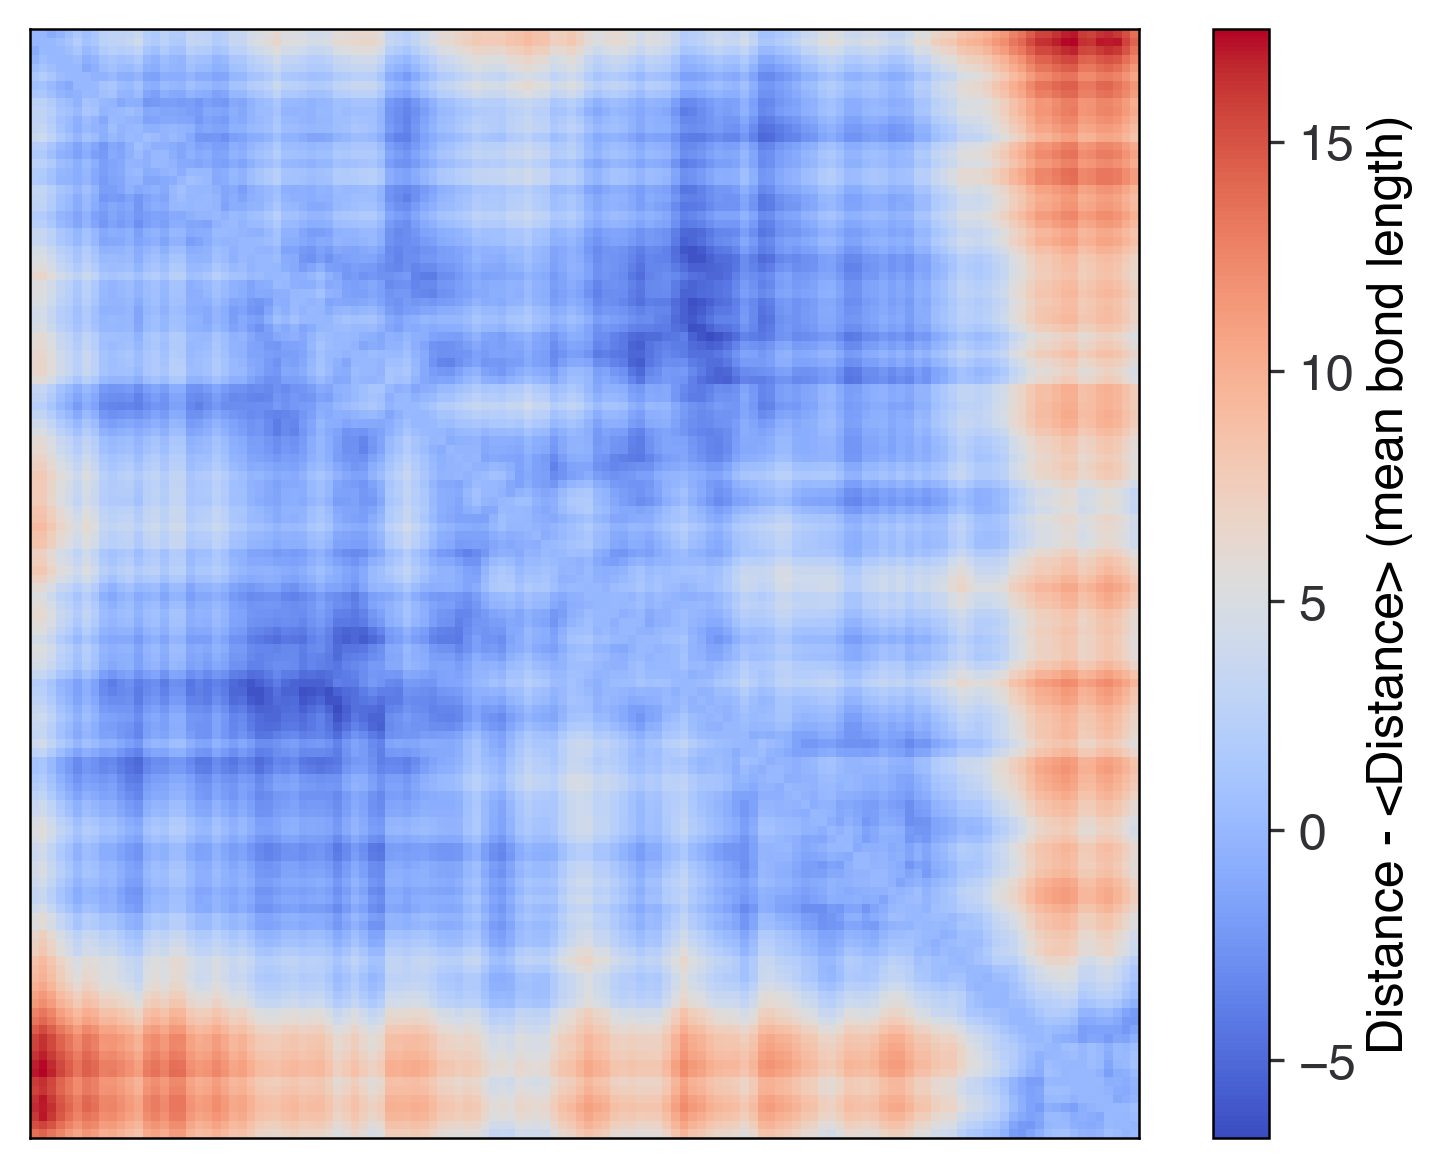

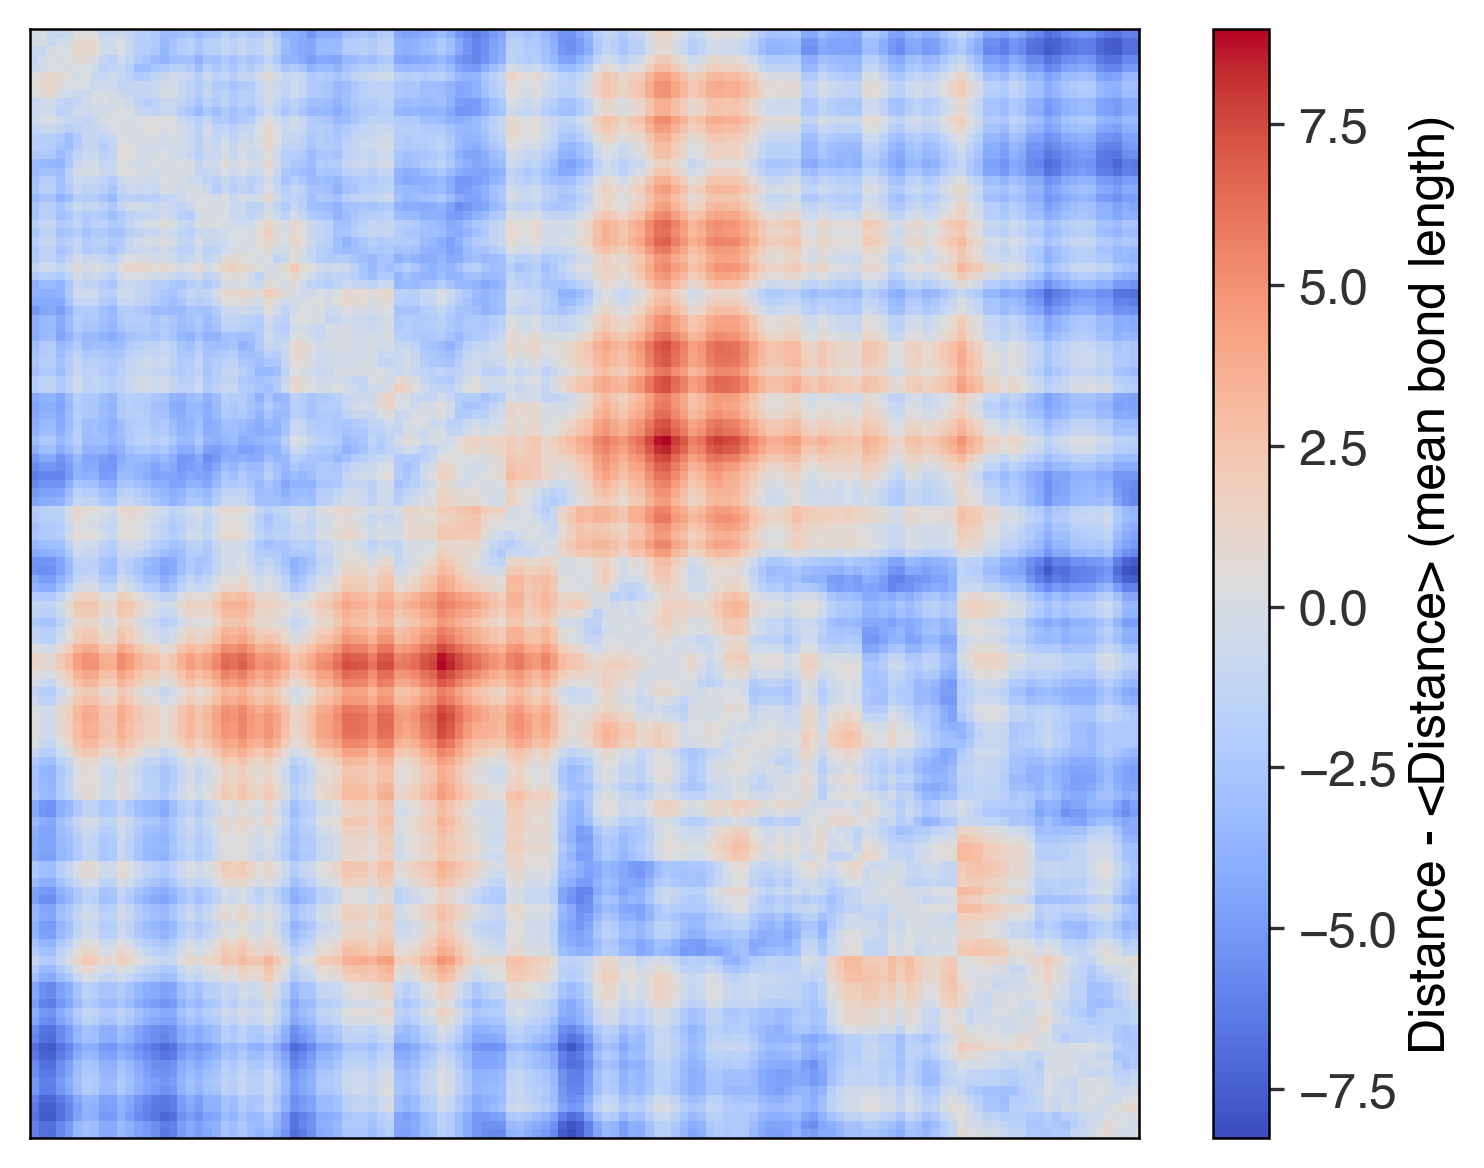

In [25]:
d_mean = dists.values.mean(0,keepdim=True)
deltas = dists[:10].values-d_mean
vmax = deltas.abs().max()
for i in range(5):#0):
    #vmax = deltas[i,...].abs().max()
    #fig,ax,im,cbar = plot_dmap(deltas[i,...],vmin=-vmax,vmax=vmax)
    fig,ax,im,cbar = plot_difference(dists[i].values,d_mean)#,vmin=-vmax,vmax=vmax)
del d_mean, deltas

CTCF Depletion

In [24]:
cond_scale = 3.5
rescaled_phi = .5
perturbed = load_dists(f'../../data/samples/origami_64_no_embed_reduction/cross_validation/CTCF/CTCT_perturb_{cond_scale}_{rescaled_phi}.pt')
unperturbed = load_dists(f'../../data/samples/origami_64_no_embed_reduction/eval_mode/sample_91_{cond_scale}_{rescaled_phi}_120_3.pt')

AssertionError: The provided settings expect the folded object to have size 64 in the final two dimensions, but received size 32

In [ ]:
chrom = '3'
region = 91 # SHOULD BE 127!!! Messed that up...

In [ ]:
num_bins=64
gen_map = tanh_map(unperturbed).prob_map
start = rosetta[chrom][region][-1]
exp_map = exp_hic.fetch(chrom=chrom,start=start,stop=start+1_280_000).prob_map

assert gen_map.shape==exp_map.shape

i,j = torch.triu_indices(gen_map.shape[-1],gen_map.shape[-1],1)
gen_map[i,j] = exp_map[i,j]
gen_map = HiCMap(gen_map)
fig,ax,im,cbar = gen_map.plot()

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{start+1_280_000:,}')
ax.text(num_bins-1,.01*num_bins,'Experimental',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

In [ ]:
chrom = '3'
region = 127

In [ ]:
num_bins=64
gen_map = tanh_map(perturbed).prob_map
start = rosetta[chrom][region][-1]
exp_map = exp_hic.fetch(chrom=chrom,start=start,stop=start+1_280_000).prob_map

assert gen_map.shape==exp_map.shape

i,j = torch.triu_indices(gen_map.shape[-1],gen_map.shape[-1],1)
gen_map[i,j] = exp_map[i,j]
gen_map = HiCMap(gen_map)
fig,ax,im,cbar = gen_map.plot()

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{start+1_280_000:,}')
ax.text(num_bins-1,.01*num_bins,'Experimental',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

##### IMR vs GM

In [ ]:
cond_scale = 1.5
rescaled_phi = .5
chrom = '11'
region = 2040
IMR = load_dists(f'../../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/chr_{chrom}_{region}_{cond_scale}_{rescaled_phi}.pt')
GM = load_dists(f'../../data/samples/origami_64_no_embed_reduction/eval_mode/sample_{region}_{cond_scale}_{rescaled_phi}_120_{chrom}.pt')

In [ ]:
num_bins=64
IMR = tanh_map(IMR).prob_map
GM = tanh_map(GM).prob_map

i,j = torch.triu_indices(IMR.shape[-1],IMR.shape[-1],1)
IMR[i,j] = GM[i,j]
IMR = HiCMap(IMR)
fig,ax,im,cbar = IMR.plot()

start = rosetta[chrom][region][-1]
ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{start+1_280_000:,}'+'\nGenerated Data')
ax.text(num_bins-1,.01*num_bins,'GM12878',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'IMR-90',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

In [ ]:
IMR_hic = HiCDataset(mcool_fp_IMR)

In [ ]:
num_bins=64
start = rosetta[chrom][region][-1]
exp_GM = exp_hic.fetch(chrom=chrom,start=start,stop=start+1_280_000).prob_map
exp_IMR = IMR_hic.fetch(chrom=chrom,start=start,stop=start+1_280_000).prob_map

i,j = torch.triu_indices(gen_map.shape[-1],gen_map.shape[-1],1)
exp_IMR[i,j] = exp_GM[i,j]
exp_IMR = HiCMap(exp_IMR)
fig,ax,im,cbar = exp_IMR.plot()

ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start:,}-{start+1_280_000:,}'+'\nExperimental Hi-C')
ax.text(num_bins-1,.01*num_bins,'GM12878',horizontalalignment='right',verticalalignment='top',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

ax.text(.01*num_bins,.995*num_bins-1,'IMR-90',horizontalalignment='left',verticalalignment='baseline',
        color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

In [ ]:
import torch
import time
a = torch.rand(10000,10000).cuda()
b = a.clone()
while True:
    c = a @ b
    time.sleep(.5)